In [1]:
#Imports
import numpy as np
import pandas as pd
import os
from utils.graph_utils import *

# Data

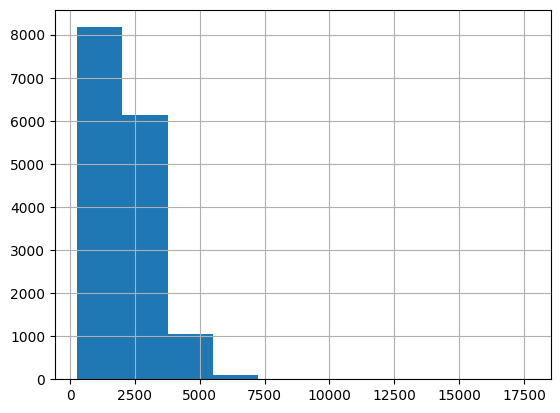

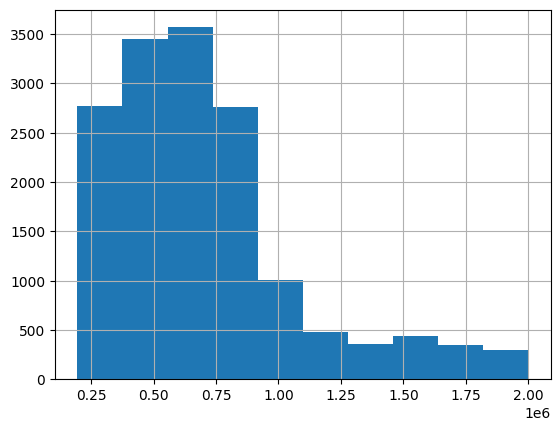

price_range
mid     8186
low     5189
high    1236
Name: count, dtype: int64

In [2]:
# Example 1

DATA_PATH = "/home/bule/TramDag/data"
# toy example  https://www.kaggle.com/datasets/ted8080/house-prices-and-images-socal

# import kagglehub
# kagglehub.dataset_download("ted8080/house-prices-and-images-socal", path=DATA_PATH)

# X0 sqrft continous
# X1 Images
# X2 Price in ranges low, mid , high 
houses_df=pd.read_csv(os.path.join(DATA_PATH ,"socal2.csv"))

# X0 -> squarfoot continous
houses_df['sqft'].hist()
plt.show()

# X1 -> images
image_paths=[os.path.join(DATA_PATH,"socal2/socal_pics",pth) for pth in os.listdir(os.path.join(DATA_PATH, "socal2/socal_pics"))]
houses_df['image_paths']=image_paths

# X2 prices -> ordinal
houses_df['price'].hist()
plt.show()
houses_df['price_range'] = pd.cut(houses_df['price'], bins=[0, 500_000, 1_000_000, 1_500_000], labels=['low', 'mid', 'high'])
houses_df['price_range'].value_counts()




# Define graph Structure

- define graph and which shift and intercept terms to use


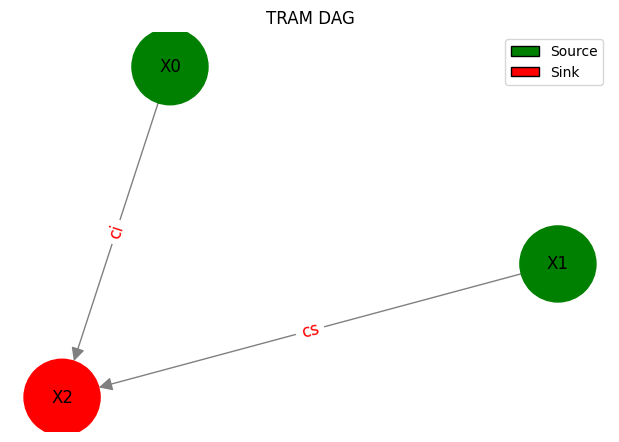

In [3]:
# describe if data is continous or  ordinal  ['cont', 'ord','other']
# note that other data than tabular can only be used as source 



# Example 1 3x3:
data_type={'X0':'cont','X1':'other','X2':'ord'}  # images, continous, continous, continous
adj_matrix = np.array([
    [ "0", "0", "ci"],  # A -> B (cs), A -> C (ls)
    [ "0", "0", "cs"],  # B -> D (ls)
    [ "0", "0", "0"],  # C -> D (cs)
], object)


# # example 2 4x4
# data_type={'X0':'other','X1':'ord','X2':'ord','X3':'ord'}  # images, continous, continous, continous    
# adj_matrix = np.array([
#                                 ["0", "ci", "ls", "ci"],  # A -> B (cs), A -> C (ls)
#                                 ["0", "0", "0", "ls"],  # B -> D (ls)
#                                 ["0", "0", "0", "cs"],  # C -> D (cs)
#                                 ["0", "0", "0", "0"]    # No outgoing edges from D
#                             ], dtype=object)


plot_dag(adj_matrix,data_type, seed=42)

# Configuration for the Models

- all SI and LS model are generated outmatically since these are shallow NN's
- CI and CS have to be defined by the User and can be Passed for each model, -> generate default networks which are generated automaitcally

************* 
 Model has Complex intercepts and Coomplex shifts , please add your Model to the modelzoo 
************


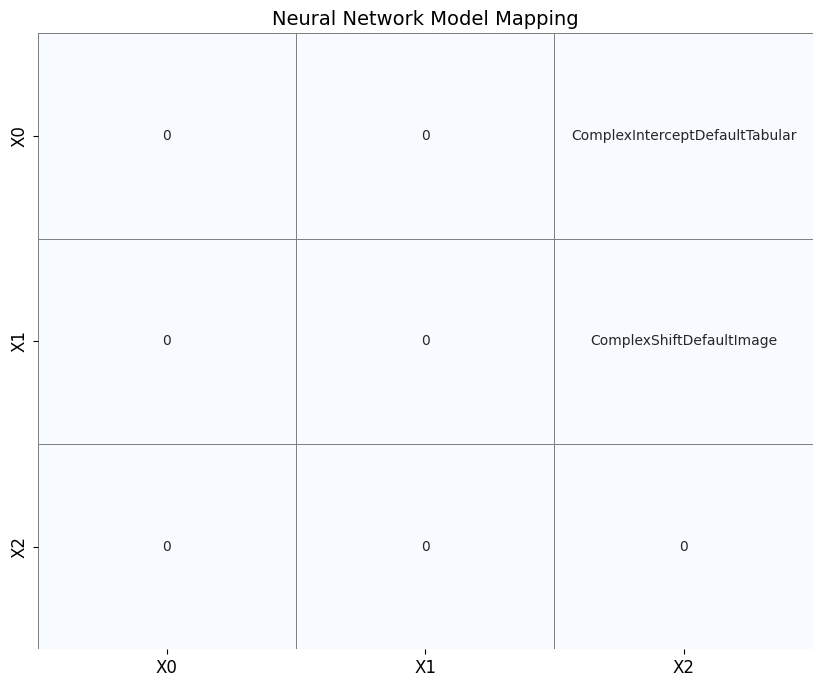

In [4]:
# check if there are Ci or Compelx shifts in the models. If yes define the modelnames
nn_names_matrix= create_nn_model_names(adj_matrix,data_type)
plot_nn_names_matrix(nn_names_matrix)
## BUG has bug does not find the correct modelnames for the nn image should have x= -X1 should be cS imagedate defalut

- add custom models for the ci or cs

In [5]:
# TODO: fucniton to automate
# if different models should be used, defin model in utils.models 
# e.g ComplexInterceptCUSTOMImage # any possible eg VITS

# rename the modelnames in the nn_names_matrix
# e.g.nn_names_matrix[2,3]='ComplexInterceptCUSTOMImage'  

- model configurations

In [6]:
conf_dict=get_configuration_dict(adj_matrix,nn_names_matrix, data_type)
conf_dict

{'X0': {'Modelnr': 0,
  'data_type': 'cont',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'X1': {'Modelnr': 1,
  'data_type': 'other',
  'node_type': 'source',
  'parents': [],
  'parents_datatype': [],
  'transformation_terms_in_h()': {},
  'transformation_term_nn_models_in_h()': {}},
 'X2': {'Modelnr': 2,
  'data_type': 'ord',
  'node_type': 'sink',
  'parents': ['X0', 'X1'],
  'parents_datatype': ['cont', 'other'],
  'transformation_terms_in_h()': {'X0': 'ci', 'X1': 'cs'},
  'transformation_term_nn_models_in_h()': {'X0': 'ComplexInterceptDefaultTabular',
   'X1': 'ComplexShiftDefaultImage'}}}

## Fit models

- each model independently fitting

In [7]:
from utils.ontram_models import *

In [ ]:
for node in conf_dict:
    print(f'\n----------node {node}--------')
    
    
    
    ######################################################## 1. Create Ontram Model ######################
    # TODO add args to the models via config file eg nn_int = globals()[nn_int_name](args) , args from conf
    
    
    #*************
    # aligning with code from lisa the ontram model takes a nn_int and a list of nn_shifts
    # -> nn_int is the intercept term
    # -> nn_shifts is a list of models that are used for the shift terms
    # if there are no shift terms, nn_shifts is None
    #**********
    
    ### iF node is a source -> no deep nn is needed
    if conf_dict[node]['node_type'] == 'source':
        print('>>>>>>>>>>>>  source node --> only  modelled only  by si')
        nn_int = SimpleIntercept()
        ontram_model = OntramModel(nn_int, None)  
        print(ontram_model)
        
    ### if node is not a source node 
    else:
        # read terms and model names form the config
        terms_dict=conf_dict[node]['transformation_terms_in_h()']
        model_names_dict=conf_dict[node]['transformation_term_nn_models_in_h()']
        
        # Combine terms and model names and divide in intercept and shift terms
        model_dict=merge_transformation_dicts(terms_dict, model_names_dict)
        intercepts_dict = {k: v for k, v in model_dict.items() if "ci" in v['h_term'] or 'si' in v['h_term']}        
        shifts_dict = {k: v for k, v in model_dict.items() if "ci" not in v['h_term'] and  'si' not in v['h_term']}        
        
        # make sure that nns are correctly defined afterwards
        nn_int, nn_shifts_list = None, None
        
        # intercept term
        if not np.any(np.array([True for diction in intercepts_dict.values() if 'ci' in diction['h_term']]) == True):
            print('>>>>>>>>>>>> No ci detected --> intercept defaults to si')
            nn_int = SimpleIntercept()
        
        else:
            
            # intercept term -> model
            nn_int_name = list(model_names_dict.items())[0][1]
            nn_int = globals()[nn_int_name]()
        
        # shift term -> lsit of models         
        nn_shift_names=[v["class_name"] for v in shifts_dict.values() if "class_name" in v]
        nn_shifts_list = [globals()[name]() for name in nn_shift_names]
        
        # ontram model
        ontram_model = OntramModel(nn_int, nn_shifts_list)    
        print(ontram_model)
        
    ##################################################### 2. Create Dataloaders ######################
    
    
    
    if conf_dict[node]['node_type'] == 'source':
        print('>>>>>>>>>>>>  source node --> Datalaoder only consists of target')
        
    
    
    else:
    node['parents']


IndentationError: expected an indented block (2658672149.py, line 60)

# Sample